# Image Deblurring - June Exam
# Mohammad Amin Nazerzadeh - 0001032832

---



# Introduction:
In this project, we had a task of removing gaussian blurring and gaussian noise from images of CIFAR10 dataset. The CIFAR10 consists of 60000 32*32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 
I designed two main models, which the latter performed the best. The model, tries to remove gaussian blurring by the aid of edge detection. 
I will explain the details as follows.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import Sequential
import albumentations as A
import matplotlib.pyplot as plt
from cv2 import Canny

### Dataset creation - DO NOT MODIFY

In [ ]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

In [ ]:
(x_train, y_train), (x_test, y_test) = getDataset()

In [ ]:
x_train.shape

(50000, 32, 32, 3)

###Insight:
 In opencv gaussian blurring, different channels are processed independently.

# Original Images vs blurred


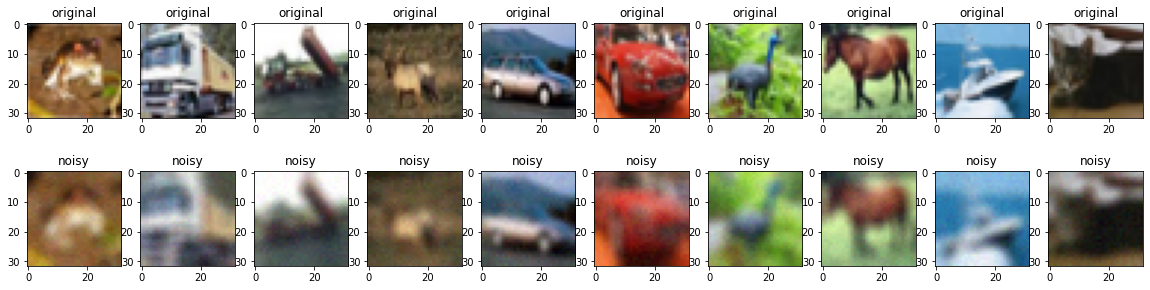

In [ ]:
import matplotlib.pyplot as plt
n_rows = 2
n_cols = 10
fig , ax = plt.subplots(n_rows, n_cols, figsize = (20,5))
for i in range(n_rows):
  for j in range(n_cols):
    if i ==0 :
      ax[i,j].imshow(y_train[j])
      ax[i,j].set_title('original')
    else:
      ax[i,j].imshow(np.clip(x_train[j],0,1))
      ax[i,j].set_title('noisy')

# Data Augmentation:
For the augmentation I need a way to augment both the original and the noisy images with the same transform. I exploited ["Albumentations"](https://albumentations.ai/docs/getting_started/simultaneous_augmentation/) [5] library for that.

In [ ]:
from albumentations.augmentations.transforms import VerticalFlip
def augmentor (input, transform):
  x = input[0]
  y = input[1]
  transformed = transform(image= x, image0 = y)
  return transformed['image'], transformed['image0']

transform_horizontal = A.Compose(
    [
        A.HorizontalFlip(p=1)
    ],
    additional_targets={'image0': 'image'}
)
transform_vertical = A.Compose(
    [
        A.VerticalFlip(p = 1)
    ],
    additional_targets={'image0': 'image'}
)

augmented_horizontal =  np.array([ augmentor(input, transform_horizontal) for input in zip(x_train, y_train)])
augmented_vertical = np.array([augmentor(input, transform_vertical) for input in zip(x_train, y_train)])

x_horizontal = augmented_horizontal[:,0,...]
y_horizontal = augmented_horizontal[:,1,...]
x_vertical = augmented_vertical[:,0,...]
y_vertical = augmented_vertical[:,1,...]

x_train = np.concatenate([x_train, x_horizontal, x_vertical])
y_train = np.concatenate([y_train, y_horizontal, y_vertical])

Due to the nature of gaussian blurring, the edges are affected the most by it. 
This model, adapted from [Edge-Aware Deep Image Deblurring](https://arxiv.org/abs/1907.02282) [1], stresses on the fact that gaussian blurring effects edges of an image the most. So, in their proposed model, they tried to decouple the task of edge detection and the task of deblurring. By doing so, they could first estimate the edges of an image, and then pass it to the deblurring model as a fourth channel to use that information for deblurring the image. 
Here is a scheme of their network:
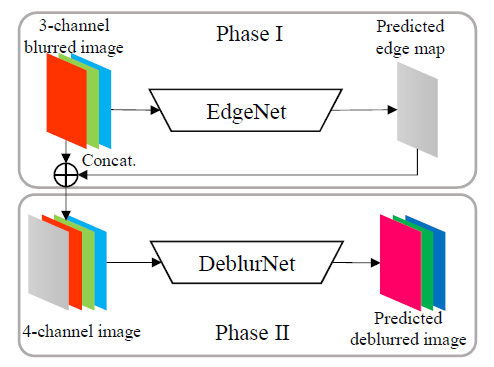




*   For the **EdgeNet**, they had a model inspired by [Holistically-nested Edge Detection](https://openaccess.thecvf.com/content_iccv_2015/html/Xie_Holistically-Nested_Edge_Detection_ICCV_2015_paper.html) [2] structure as you can see in the bottom picture. 
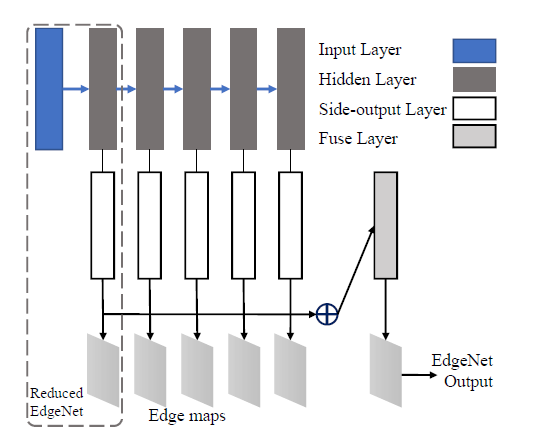

They also used a gan-like architecture to stabalize the training of the **EdgeNet**. I developed the gan edgeNet but the result was not good and the training was not stable enough. So I proceeded with the simple EdgeNet architecture. For the training part, they used [canny edge detector](https://ieeexplore.ieee.org/document/4767851) [3] to generate the ground truth edge maps.  

* For the **DeblurNet**, they used a generative CNN architecture consisting of one global skip connection, residual convolutional blocks, and upsampling convolutional blocks. The image of the structure is found below:
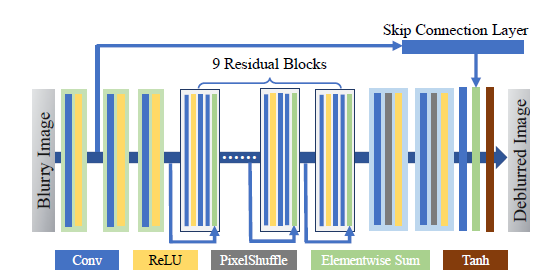



# EdgeNet based on GAN

In [ ]:
!pip install -U tensorflow-addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Results of applying canny edge detector filter on the input images:

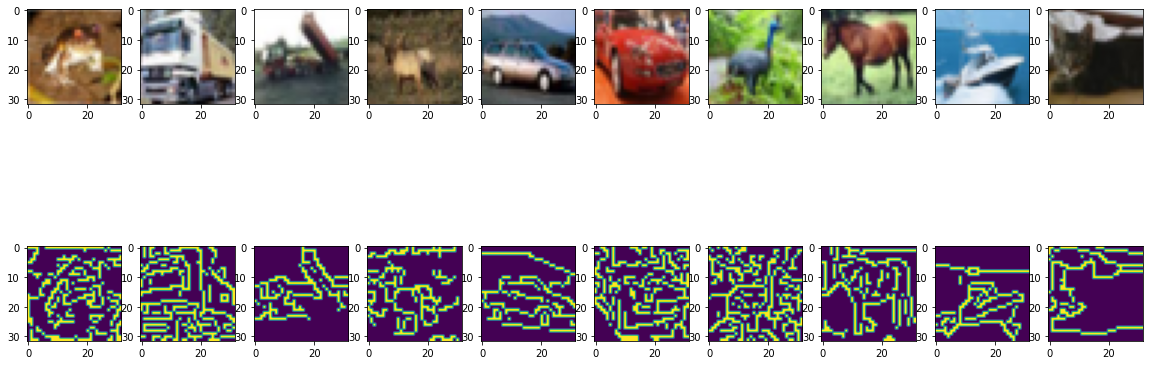

In [ ]:
n_rows = 2
n_cols = 10
fig , ax = plt.subplots(n_rows, n_cols, figsize = (20,8))
for i in range(n_rows):
  for j in range(n_cols):
    if i ==0 :
      ax[i,j].imshow(y_train[j])
    else:
      ax[i,j].imshow(Canny(np.array(255 * y_train[j], dtype = 'uint8'),100,200)/255)

In [ ]:
#The ground-truth for training the generator
y_edge_train = np.array([Canny(np.array(255 * x, dtype = 'uint8'),100,200)/255 for x in y_train])
y_edge_test = np.array([Canny(np.array(255 * x, dtype = 'uint8'),100,200)/255 for x in y_test])

For the discriminator, they used [Sepctral Normalization](https://arxiv.org/abs/1802.05957) [4], which is a method for stabalizing the training of the discriminator in GAN networks.

In [ ]:
def build_discriminator(shape):
  input = layers.Input(shape = shape)
  x = tfa.layers.SpectralNormalization(layers.Conv2D(64, (5,5), activation = 'leaky_relu', padding = 'same'))(input)
  x = layers.MaxPool2D((2,2))(x)
  x = tfa.layers.SpectralNormalization(layers.Conv2D(128, (3,3),activation = 'leaky_relu', padding = 'same'))(x)
  x = layers.MaxPool2D((2,2))(x)
  x = tfa.layers.SpectralNormalization(layers.Conv2D(256, (2,2), strides = 2, activation = 'leaky_relu', padding = 'same'))(x)
  x = layers.MaxPool2D((2,2))(x)
  x = tfa.layers.SpectralNormalization(layers.Conv2D(512, (2,2), strides = 2, activation = 'leaky_relu', padding = 'same'))(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation = 'relu')(x)
  output = layers.Dense(1, activation = 'sigmoid')(x)
  discriminator = Model(input, output)
  discriminator.compile(optimizer='adam', loss = 'BinaryCrossentropy')
  discriminator.summary()
  return discriminator

In [ ]:
def build_generator(shape):
  input = layers.Input(shape = shape)
  x1 = layers.Conv2D(32, (5,5), activation='swish', strides = 2, padding = 'same', name = 'Hidden_layer_1')(input)
  x2 = layers.Conv2D(32, (3,3), activation = 'swish', strides = 2, padding = 'same')(input)
  x1 = layers.Concatenate()([x1,x2])
  x2 = layers.Conv2D(64, (3,3), activation='swish', strides = 2,padding = 'same', name = 'Hidden_layer_2')(x1)
  x4 = layers.Conv2D(64, (5,5), activation = 'swish', strides = 2, padding = 'same')(x1)
  x2 = layers.Concatenate()([x2,x4])
  x3 = layers.Conv2D(128, (3,3), activation = 'swish', strides = 2, padding = 'same')(x2)
  x4 = layers.Conv2D(256, (2,2), activation = 'swish', strides = 2,padding = 'same', name = "Hideen_layer4")(x3)
  side1 = layers.Conv2D(512, (1,1),activation = 'swish', padding = 'same', name = 'Side_output_layer1')(x1)
  side2 = layers.Conv2D(512, (1,1), activation = 'swish', padding = 'same', name = 'Side_output_layer2')(x2)
  side3 = layers.Conv2D(512, (1,1), activation = 'swish', padding = 'same', name = 'Side_output_layer3')(x3)
  side4 = layers.Conv2D(512, (1,1), activation = 'swish', padding = 'same', name = 'Side_output_layer4')(x4)
  
  y2 = layers.Conv2DTranspose(32, (3,3), strides = 2, activation = 'swish', padding = 'same')(side1)
  y3 = layers.Conv2DTranspose(32, (5,5), strides = 2, activation = 'swish', padding = 'same')(side1)
  y1 = layers.Concatenate()([y2,y3])
  y3 = layers.Conv2DTranspose(64, (3,3), strides = 4, activation = 'swish', padding = 'same')(side2)
  y4 = layers.Conv2DTranspose(64, (5,5), strides = 4, activation = 'swish', padding = 'same')(side2)
  y2 = layers.Concatenate()([y3,y4])
  y3 = layers.Conv2DTranspose(128, (3,3), strides = 8, activation = 'swish', padding = 'same')(side3)
  y4 = layers.Conv2DTranspose(256, (2,2), strides = 16,activation = 'swish', padding = 'same')(side4)
  y = layers.Concatenate()([y1,y2,y3,y4])
  output = layers.Conv2D(1, (3,3), activation = 'sigmoid', padding = 'same')(y)
  edgenet = Model(input, output)
  edgenet.compile(optimizer='adam', loss = 'BinaryCrossentropy')
  edgenet.summary()
  return edgenet

In [ ]:
batch_size = 64
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
epochs = 100
discriminator = build_discriminator(shape = (32,32,1))
generator = build_generator(shape = (32,32,3))
combined = Sequential()
combined.add(generator)
combined.add(discriminator)
combined.compile(optimizer='adam', loss = 'BinaryCrossentropy')
combined.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 spectral_normalization (Spe  (None, 32, 32, 64)       1728      
 ctralNormalization)                                             
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 spectral_normalization_1 (S  (None, 16, 16, 128)      73984     
 pectralNormalization)                                           
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                         

In the GAN model generator (which is the edge detector in this case) and the discriminator train interchangably (increasing the number of training steps of the generator gradually). Also to take into account the MSE loss, the generator is also trained taking into account the MSE loss between the generated output and the ground-truth which is resulted by a canny edge-detector.

I have included here the code only for the implementation. The results are omitted as the running of the code would take so long to reach a good and stable score.

In [ ]:
# g_loss = 0
# d_loss = 0
# edge_loss = 0
# for epoch in range(epochs):

#   # ---------------------
#   #  Train Discriminator
#   # ---------------------
#   # Select a random batch of images

#   for i in range(10 + epoch):
#     idx = tf.random.uniform((batch_size,), minval = 0, maxval = y_edge_train.shape[0], dtype = tf.dtypes.int32)
#     imgs = y_edge_train[idx]

#     idx = tf.random.uniform((batch_size,), minval = 0, maxval = y_edge_train.shape[0], dtype = tf.dtypes.int32)
#     imgs_noise = x_train[idx]

#     gen_imgs = generator(imgs_noise)

#     # Generate a batch of new images

#     # Train the discriminator
#     discriminator.trainable = True
#     d_loss_real = discriminator.train_on_batch(imgs, valid)
#     d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
#     d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
#   print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss, g_loss))

#   # ---------------------
#   #  Train Generator
#   # ---------------------


#   for i in range(5 + round(epoch * 1.5)):

#     discriminator.trainable = False
#     idx = tf.random.uniform((batch_size,), minval = 0, maxval = x_train.shape[0], dtype = tf.dtypes.int32)
#     imgs_noise = x_train[idx]


#     # Train the generator (to have the discriminator label samples as valid)
#     g_loss = combined.train_on_batch(imgs_noise, valid)

#   print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss, g_loss))


#   # Train the generator to generate outputs considering the MSE loss compared the ground truth
#   for i in range(20 + epoch * 20):
#     idx = tf.random.uniform((batch_size,), minval = 0, maxval = y_edge_train.shape[0], dtype = tf.dtypes.int32)
#     imgs = y_edge_train[idx]


#     imgs_noise = x_train[idx]

#     gen_imgs = generator(imgs_noise)
#     edge_loss = generator.train_on_batch(imgs_noise, imgs)

#   print("%d [Edge loss %f]" %(epoch, edge_loss))


#   # Plot the progress

# Simple EdgeNet not based on GAN

In [ ]:
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(min_delta= 0.0001, patience=7, restore_best_weights = True)

In [16]:
history = generator.fit(
    x=x_train,
    y=y_edge_train,
    epochs=100,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, y_edge_test),
    callbacks = [callback]
)

Epoch 1/100
2344/2344 [==============================] - 199s 79ms/step - loss: 0.4711 - val_loss: 0.4415
Epoch 2/100
2344/2344 [==============================] - 184s 78ms/step - loss: 0.4261 - val_loss: 0.4111
Epoch 3/100
2344/2344 [==============================] - 184s 78ms/step - loss: 0.4053 - val_loss: 0.3991
Epoch 4/100
2344/2344 [==============================] - 184s 78ms/step - loss: 0.3962 - val_loss: 0.3931
Epoch 5/100
2344/2344 [==============================] - 184s 78ms/step - loss: 0.3906 - val_loss: 0.3884
Epoch 6/100
2344/2344 [==============================] - 184s 78ms/step - loss: 0.3866 - val_loss: 0.3861
Epoch 7/100
2344/2344 [==============================] - 184s 79ms/step - loss: 0.3836 - val_loss: 0.3839
Epoch 8/100
2344/2344 [==============================] - 184s 79ms/step - loss: 0.3813 - val_loss: 0.3832
Epoch 9/100
2344/2344 [==============================] - 184s 78ms/step - loss: 0.3794 - val_loss: 0.3820
Epoch 10/100
2344/2344 [======================

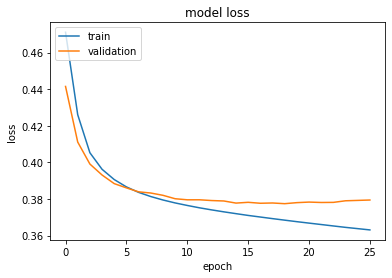

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Visualizing what the model learnt:

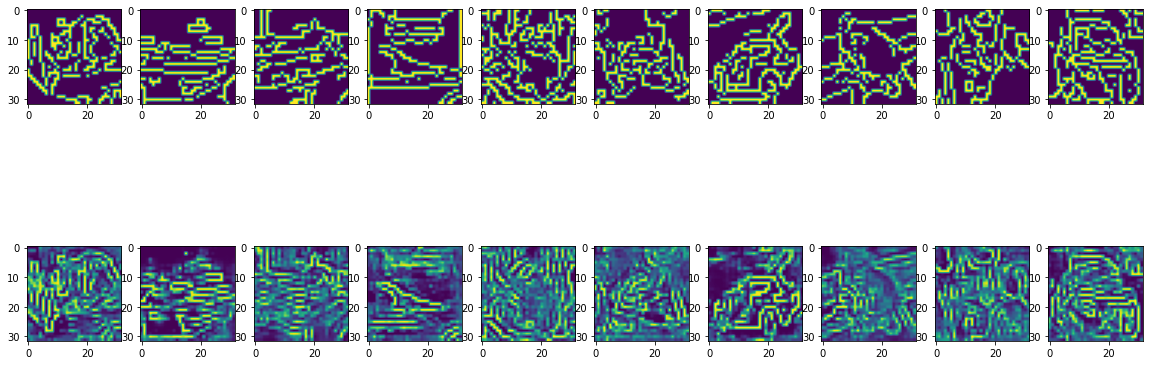

In [18]:
import matplotlib.pyplot as plt
from cv2 import Canny
n_rows = 2
n_cols = 10
fig , ax = plt.subplots(n_rows, n_cols, figsize = (20,8))
for i in range(n_rows):
  for j in range(n_cols):
    if i ==0 :
      ax[i,j].imshow(y_edge_test[j])
    else:
      ax[i,j].imshow(np.squeeze(generator(np.expand_dims(y_test[j], axis = 0))[...,0]))

# DeblurNet

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model_1 (Functional)           (None, 32, 32, 1)    3509633     ['input_3[0][0]']                
                                                                                                  
 concatenate_5 (Concatenate)    (None, 32, 32, 4)    0           ['input_3[0][0]',                
                                                                  'model_1[1][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 32, 32, 32)   3232        ['concatenate_5[0][0]']    

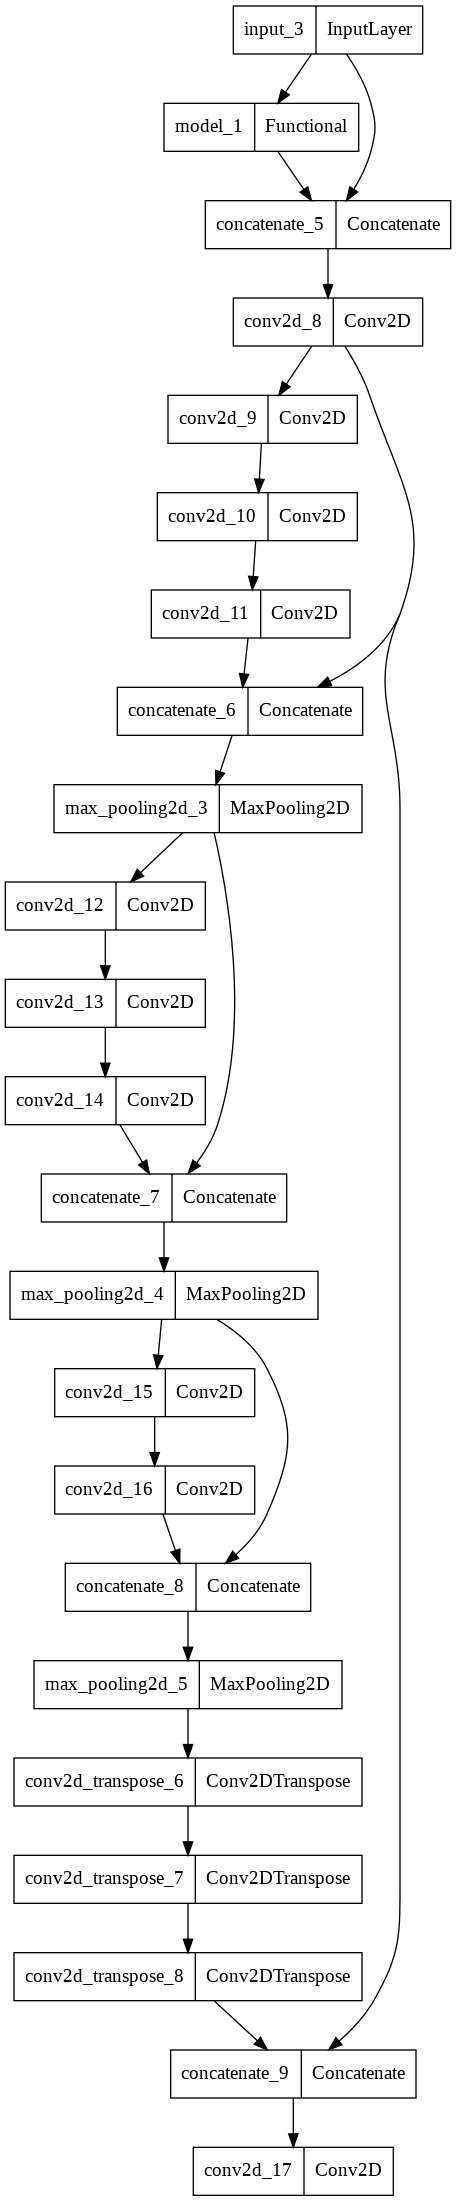

In [19]:
input = layers.Input(shape=(32, 32,3))

x = generator(input)
x = layers.Concatenate()([input, x])
x = layers.Conv2D(32, (5, 5), activation="relu", padding="same")(x)
skip_connection = x
res_input = x

#Residual blocks
x = layers.Conv2D(128 , (1,1), activation = "relu", padding = "same")(res_input)
x = layers.Conv2D(64, (3,3), activation = 'relu',  padding = 'same')(x)
x = layers.Conv2D(32, (5,5), activation = 'relu', padding = 'same')(x)
res_input = layers.Concatenate()([res_input, x])
res_input = layers.MaxPooling2D((2, 2), padding="same")(res_input)


x = layers.Conv2D(256 , (1,1), activation = "relu", padding = "same")(res_input)
x = layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same')(x)
x = layers.Conv2D(64, (5,5), activation = 'relu', padding = 'same')(x)
res_input = layers.Concatenate()([res_input, x])
res_input = layers.MaxPooling2D((2, 2), padding="same")(res_input)


x = layers.Conv2D(512 , (1,1), activation = "relu", padding = "same")(res_input)
x = layers.Conv2D(256, (3,3), activation = 'relu',padding = 'same')(x)
res_input = layers.Concatenate()([res_input, x])
res_output = layers.MaxPooling2D((2, 2), padding="same")(res_input)


#Upsampling
x = layers.Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same")(res_output)
x = layers.Conv2DTranspose(128, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)

output = layers.Concatenate()([skip_connection, x])
output = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(output)

deblurnet = Model(input, output)
deblurnet.compile(optimizer="adam", loss="MSE")
deblurnet.summary()
tf.keras.utils.plot_model(deblurnet)

In [20]:
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(min_delta= 0.0001, patience=7, restore_best_weights = True)

In [21]:
generator.trainable = False
history = deblurnet.fit(
    x=x_train,
    y=y_train,
    epochs=100,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks = [callback]
)

Epoch 1/100
2344/2344 [==============================] - 288s 121ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 2/100
2344/2344 [==============================] - 283s 121ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 3/100
2344/2344 [==============================] - 283s 121ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 4/100
2344/2344 [==============================] - 283s 121ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 5/100
2344/2344 [==============================] - 284s 121ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 6/100
2344/2344 [==============================] - 284s 121ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 7/100
2344/2344 [==============================] - 283s 121ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 8/100
2344/2344 [==============================] - 283s 121ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 9/100
2344/2344 [==============================] - 283s 121ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/100
2344/2344 [=============

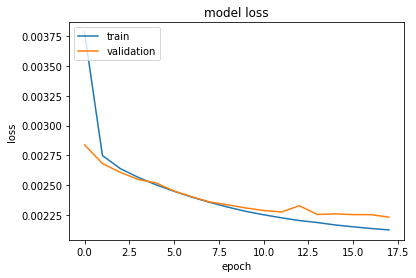

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

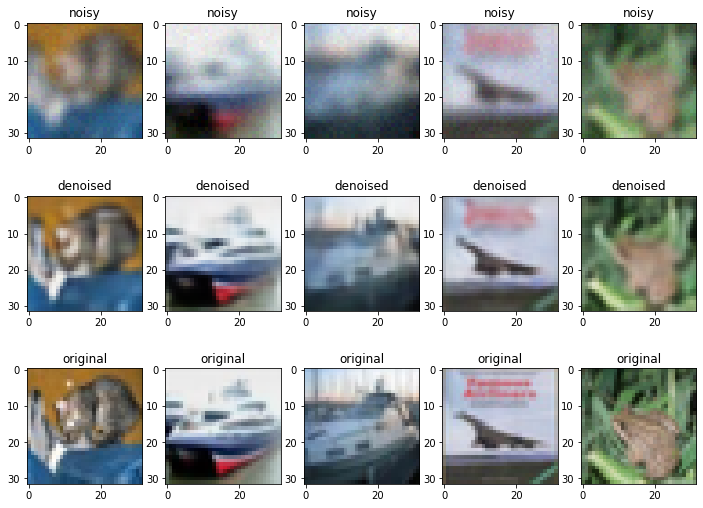

In [29]:
fig, axs = plt.subplots(3, 5, figsize=(12,9))
for i in range(0,3):
    for j in range(0,5):
      if i == 0:
        axs[i,j].imshow(np.clip(x_test[j], 0 ,1))
        axs[i,j].set_title('noisy')
      if i == 1:
        axs[i,j].imshow(np.clip(np.squeeze(deblurnet(np.expand_dims(x_test[j],0))), 0, 1))
        axs[i,j].set_title('denoised')
      if i == 2:
        axs[i,j].imshow(y_test[j])
        axs[i,j].set_title('original')
plt.show() 

### Evaluation:

In [30]:
print(deblurnet.evaluate(x_test, y_test))

313/313 [==============================] - 8s 27ms/step - loss: 0.0023
0.0022892288397997618


#Conclusion & Discussion: 
Due to the random nature of gaussian noises it is a hard task to deblur images while preserving local features of the original image. This specificially is the case here as the size of the images are low (32 * 32). I suppose that the DeblurNet + EdgeNet can score better results on high resolution images with alot of artifacts inside the image (As it is not the case in the current Dataset). One can try to explore this model on CIFAR100 to compare the results. 
Also accurate hyperparameter tunning is needed which I skipped due to the timing for this project. 

#References:
[1] Fu, Zhichao, et al. "Edge-aware deep image deblurring." arXiv preprint arXiv:1907.02282 (2019).

[2] Saining Xie, Zhuowen Tu; Proceedings of the IEEE International Conference on Computer Vision (ICCV), 2015, pp. 1395-1403

[3] J. Canny, "A Computational Approach to Edge Detection," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. PAMI-8, no. 6, pp. 679-698, Nov. 1986, doi: 10.1109/TPAMI.1986.4767851.

[4] Miyato, Takeru, et al. "Spectral normalization for generative adversarial networks." arXiv preprint arXiv:1802.05957 (2018).

[5] Buslaev, A.; Iglovikov, V.I.; Khvedchenya, E.; Parinov, A.; Druzhinin, M.; Kalinin, A.A. Albumentations: Fast and Flexible Image Augmentations. Information 2020, 11, 125. https://doi.org/10.3390/info11020125

In [ ]:
generator.save_weights("./drive/MyDrive/generator.h5")
deblurnet.save_weights("./drive/MyDrive/deblurnet.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
